In [37]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import seaborn as sns
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.colors import Normalize

df = pd.read_csv('coordinates_clusters.csv')
coords = df.sample(5000).as_matrix(columns=['lat_fixed', 'lon_fixed'])
# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 0.5 / kms_per_radian

In [24]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(coords), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 5,000 points down to 108 clusters, for 99.9% compression in 0.23 seconds
Silhouette coefficient: -0.309


In [13]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [14]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [15]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lat,lon
103,40.7576,-73.9306
104,40.7796,-73.7804
105,40.7057,-73.8122
106,40.7550,-73.8145
107,40.6320,-74.0218


In [17]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['lat_fixed']==row['lat']) & (df['lon_fixed']==row['lon'])].iloc[0], axis=1)
rs.tail()

,listing_id,lat_fixed,lon_fixed,locations_kde,0.2km,0.5km,0.75km,1.0km,1.5km,2.5km,4km
103,7164021,40.7576,-73.9306,1.978866,18,0,0,0,0,0,0
104,6894530,40.7796,-73.7804,-1.174460,13,4,2,2,2,0,0
105,7164552,40.7057,-73.8122,0.876341,361,0,0,0,0,0,0
106,7147991,40.7550,-73.8145,-0.053148,100,7,4,4,2,0,0
107,6917816,40.6320,-74.0218,1.820838,10,0,0,0,0,0,0


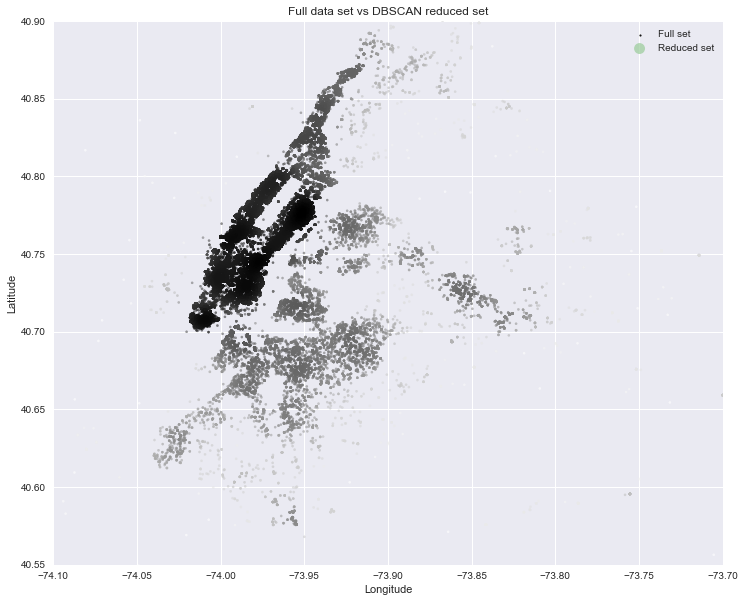

In [41]:
# plot the final reduced set of coordinate points vs the original full set
cmap = cm.autumn
norm = Normalize(vmin=df.locations_kde.min(), vmax=df.locations_kde.max())

fig, ax = plt.subplots(figsize=[12, 10])
# rs_scatter = ax.scatter(rs['lon_fixed'], rs['lat_fixed'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
# df_scatter = ax.scatter(df['lon_fixed'], df['lat_fixed'], c='k', alpha=0.9, s=3)
kde_scatter = ax.scatter(df['lon_fixed'], df['lat_fixed'], c=norm(df['locations_kde']), alpha=0.6, s=5)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-74.1,-73.7])
ax.set_ylim([40.55,40.9])
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [21]:
rs.head()

,listing_id,lat_fixed,lon_fixed,locations_kde,0.2km,0.5km,0.75km,1.0km,1.5km,2.5km,4km
0,6881778,40.7656,-73.8227,1.186539,95,7,4,4,2,0,0
1,7033313,40.7569,-73.9774,4.945576,1,0,0,0,0,0,0
2,6944369,40.7267,-73.8569,2.872473,3,0,0,0,0,0,0
3,6917746,40.6796,-73.9523,3.025111,0,0,0,0,0,0,0
4,6813023,40.6927,-73.9860,3.705424,19,0,0,0,0,0,0
